In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 学習データ作成

## 緯度経度データと標高データの取得

In [4]:
# ピクセルの緯度経度を返す関数
def pixel_to_latlng(pixel_x, pixel_y,zoom = 7):
    L = 85.05112878
    longitude = 180*(pixel_x/(2**(zoom+7))-1)
    latitude = 180*(np.arcsin(np.tanh(-np.pi*pixel_y/(2**(zoom+7))+np.arctanh(np.sin(np.pi*L/180)))))/np.pi
    return latitude,longitude

# タイル画像の緯度経度、標高のデータフレームを返す関数
def get_hyoko(x, y, z):
    
    # 任意のタイル画像の1ピクセルの標高を256×256のデータフレームで取得
    url = "https://cyberjapandata.gsi.go.jp/xyz/demgm/{z}/{x}/{y}.txt".format(z=z,x=x,y=y)
    df = pd.read_csv(url, header=None).replace("e",0)
    ind = []
    col = []
    
    # 取得した画像のピクセルの緯度経度を取得
    for i in range(256):
        a, b = pixel_to_latlng(x*256 + i, y*256 + i,zoom = z)
        ind.append(a)
        col.append(b)

    # データフレームの列を経度に、行を緯度に変換
    df.index = ind
    df.columns = col
    
    # 標高の値をflaat型に変換
    df = df.astype(float)

    # 標高が0より高い地点の緯度経度と標高のデータフレームを返す
    latlon = []
    for k in df.columns:
        ind = df[df[k]>0][k].index
        hyoko = df[df[k]>0][k].values
        for i, h in zip(ind, hyoko):
            latlon.append([h, i, k])

    return pd.DataFrame(latlon, columns = ['標高', '緯度', '経度'])

In [5]:
# zoom率　5で日本があるタイル画像の緯度経度、標高を取得
h1 = get_hyoko(29,11,5)
h2 = get_hyoko(28,11,5)
h3 = get_hyoko(28,12,5)
h4 = get_hyoko(27,12,5)
h5 = get_hyoko(27,13,5)

In [6]:
# 韓国、ロシア等の不要な所を削除
h2 = h2[h2['緯度']<45.583289]
h2 = h2[h2['経度']>138.339843]
h3_1 = h3[(h3['緯度']<33.961586)&(h3['経度']>128.397216)]
h3_2 = h3[(h3['経度']>130.198974)&(h3['緯度']>33.961586)]
h3 = pd.concat([h3_1, h3_2])
h1 = h1[h1['経度']<149.161376]
ans = pd.concat([h5,h4,h3,h2,h1])
ans = ans[~((ans['緯度']>34.786739)&(ans['経度']<131.022949))]
ans = ans[~((ans['緯度']>33.491016)&(ans['経度']<128.979492))]
ans = ans[~((ans['緯度']>32.768800)&(ans['経度']<127.199707))]

In [10]:
ans.to_pickle('jp.pickle')

## 各データを合体

In [11]:
# 緯度経度データとその地点の標高データ
data = pd.read_pickle('jp.pickle')

# NO2とCOのデータ
air_df = pd.read_pickle('air.pickle')

# 夜間光データ
light_df = pd.read_pickle('light.pickle')

In [12]:
# 緯度経度、標高データに合わせてNO2、CO、夜間光データを合体する
from tqdm.notebook import tqdm

ans=[]

for x,y,h in tqdm(zip(data['経度'], data['緯度'], data['標高'])):
    z1 = air_df[(air_df['x_min']<x) & (x < air_df['x_max']) & (air_df['y_min']<y) & (y < air_df['y_max'])]
    z2 = z1['no2'].values.mean()
    z3 = z1['co'].values.mean()
    z4 = light_df[(light_df['x_min']<x) & (x < light_df['x_max']) & (light_df['y_min']<y) & (y < light_df['y_max'])]
    z4 = z4['light'].values.mean()
    ans.append([z2,z3,z4,h,x,y])
        

ans = pd.DataFrame(ans,columns=['NO2','CO','light','標高','緯度','経度'])

0it [00:00, ?it/s]

C:\Users\umeyu\AppData\Local\Temp/ipykernel_21348/1173250294.py:8: RuntimeWarning: Mean of empty slice.
  z2=z1['no2'].values.mean()
C:\Users\umeyu\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\umeyu\AppData\Local\Temp/ipykernel_21348/1173250294.py:9: RuntimeWarning: Mean of empty slice.
  z3=z1['co'].values.mean()
C:\Users\umeyu\AppData\Local\Temp/ipykernel_21348/1173250294.py:11: RuntimeWarning: Mean of empty slice.
  z4=z4['light'].values.mean()


In [13]:
ans

NO2        CO  light      標高          緯度         経度
0        NaN       NaN    NaN   19.48  123.750000  24.447150
1        NaN       NaN    NaN   73.48  123.750000  24.407138
2      665.0  467242.0    NaN  173.70  123.750000  24.367114
3      664.0  459437.0    NaN  210.30  123.750000  24.327077
4      646.0  460574.0    NaN  100.03  123.750000  24.287027
...      ...       ...    ...     ...         ...        ...
28371  676.0  378109.0    NaN  183.51  148.842773  45.490946
28372    NaN       NaN    NaN  134.80  148.842773  45.429299
28373  688.0  363591.0    NaN  269.10  148.842773  45.398450
28374  673.0  360824.0    NaN   39.62  148.842773  45.367584
28375    NaN       NaN    NaN   14.50  148.886719  45.521744

[28376 rows x 6 columns]

In [48]:
ans.to_pickle('data3.pickle')

# モデル作成

平成30年と令和1年の冬期のデータを用いてモデル作成とモデル評価をする。

## trainデータ=H30 testデータ=R1の場合

In [2]:
train=pd.read_pickle('result_H30.pickle')
test=pd.read_pickle('result_R1.pickle')

In [3]:
train.drop(['都道府県'], axis=1, inplace=True)
test.drop(['都道府県'],axis=1, inplace=True)

In [4]:
X_train = train.drop(['キレイ度'], axis=1)
y_train = train['キレイ度']
X_test = test.drop(['キレイ度'], axis=1)
y_test = test['キレイ度']

### パラメータチューニングする前

In [5]:
import xgboost as xgb

model = xgb.XGBRegressor(random_state=100)
model.fit(X_train, y_train)
y_pred_pre = model.predict(X_test)

#モデルに学習データとテストデータを入れ、それぞれのスコアを見ることにより、過学習の度合いを見る。
#２つの差が小さいほど、過学習していない。
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

0.9962166520216538
0.5786967280462428


In [6]:
importances=pd.DataFrame({'fetures':X_train.columns,'importance':model.feature_importances_})
importances.sort_values('importance',ascending=False)

fetures  importance
2   light    0.829288
0     NO2    0.076499
1      CO    0.053978
3      標高    0.040236

### パラメータチューニングした後

In [7]:
model = xgb.XGBRegressor(booster = 'gbtree',
                         objective = 'reg:linear',
                         eval_metric = 'rmse',
                         random_staate=100,
                         eta = 0.3,
                         n_estimators= 120,
                         max_depth = 1,
                         min_child_weight = 6,
                         colsample_bytree = 1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#モデルに学習データとテストデータを入れ、それぞれのスコアを見ることにより、過学習の度合いを見る。
#２つの差が小さいほど、過学習していない。
print(model.score(X_train,y_train))
print(model.score(X_test, y_test))

[15:14:08] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:14:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "random_staate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.8346749533259937
0.7498710535295827


In [8]:
importances=pd.DataFrame({'fetures':X_train.columns,'importance':model.feature_importances_})
importances.sort_values('importance',ascending=False)

fetures  importance
2   light    0.859310
0     NO2    0.088366
3      標高    0.029577
1      CO    0.022747

### 散布図

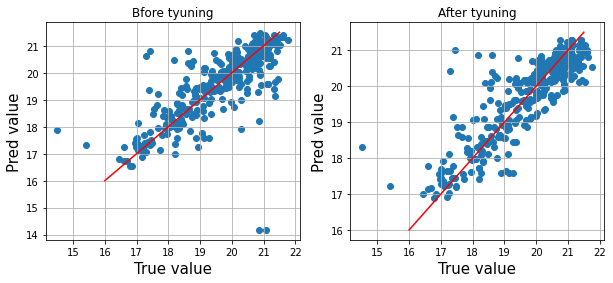

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# パラメータチューニングする前後での散布図を並べている。

fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_pre)
x = np.linspace(16,21.5)
y = x
plt.plot(x,y,'r')
plt.xlabel('True value', fontsize=15)
plt.ylabel('Pred value', fontsize=15)
plt.title('Bfore tyuning', fontsize=12)
plt.grid()

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred)
x = np.linspace(16,21.5)
y = x
plt.plot(x,y,'r')
plt.xlabel('True value', fontsize=15)
plt.ylabel('Pred value', fontsize=15)
plt.title('After tyuning', fontsize=12)
plt.grid()
plt.show()

### 誤差分布

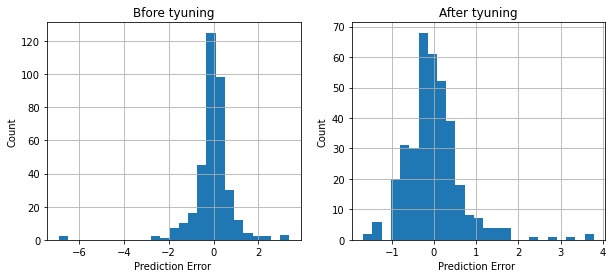

In [10]:
# パラメータチューニングする前後での予測値と実測値の差のヒストグラムを並べている。

fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
error = y_pred_pre - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error ")
plt.ylabel("Count")
plt.title('Bfore tyuning')
plt.grid()

plt.subplot(1,2,2)
error = y_pred - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error ")
plt.ylabel("Count")
plt.title('After tyuning')
plt.grid()

### 外れ値の解析

In [11]:
import scipy.stats as st

dff=pd.DataFrame(y_pred-y_test).rename(columns={'キレイ度':'誤差'})

#誤差を標準化
dff_std=pd.DataFrame(st.zscore(y_pred-y_test))
dff_std.columns=['誤差_std']
dff_std.index=dff.index

#95%
dff_index_list=dff_std[abs(dff_std['誤差_std'])>1.96].index

y_pred_df= pd.Series(y_pred)
test=pd.read_pickle('result_R1.pickle')
a=pd.concat([test, dff],axis=1)
y_pred_df.index=a.index
a['予測']=y_pred_df
out= a.loc[dff_index_list]

In [12]:
# 誤差が大きい5%の地点を表示
out

キレイ度     NO2        CO      light      標高 都道府県        誤差         予測
69   15.41  1853.0  450240.0  62.333333    81.8  東京都  1.814417  17.224417
89   18.71   851.0  405694.0  11.000000    16.0  新潟県  1.580405  20.290405
115  18.78   871.0  367881.0   9.500000   699.5  長野県  1.437951  20.217951
116  18.62   846.0  375181.0  12.000000   699.6  長野県  1.765586  20.385586
120  18.17   809.0  338923.0   6.000000   883.8  長野県  2.698557  20.868557
121  18.61   804.0  335170.0   6.000000   891.9  長野県  2.258557  20.868557
128  17.39   856.0  372756.0  56.000000   568.2  長野県  1.746744  19.136744
188  17.43   811.0  345267.0   6.000000  1092.6  長野県  3.577565  21.007565
201  18.59   788.0  360197.0  14.000000   709.7  長野県  1.528658  20.118658
228  18.40   844.0  362300.0  33.000000   742.3  長野県  1.693496  20.093496
229  18.55   838.0  366182.0  31.000000   705.0  長野県  1.391620  19.941620
230  19.44   813.0  359844.0   6.500000   934.2  長野県  1.341351  20.781351
242  17.29   806.0  342152.0  16.000000  1529.5  長野県  3.136098  20.426098
269  14.51  1214.0  436788.0  61.500000     2.7  三重県  3.789011  18.299011
280  19.13  1436.0  440564.0  63.000000    93.9  兵庫県 -1.540027  17.589973
283  19.27  1436.0  440564.0  63.000000    94.0  兵庫県 -1.680027  17.589973
284  19.05  1419.0  437883.0  63.000000    99.9  兵庫県 -1.417638  17.632362
285  17.52  1285.0  431609.0  41.000000     3.1  兵庫県  1.343838  18.863838
346  21.55  1082.0  424349.0   7.000000   421.5  岡山県 -1.434686  20.115314

## trainデータ=R1 testデータ=H30の場合

In [55]:
test=pd.read_pickle('result_H30.pickle')
train=pd.read_pickle('result_R1.pickle')

In [56]:
test.drop(['都道府県'], axis=1, inplace=True)
train.drop(['都道府県'],axis=1, inplace=True)

In [57]:
X_train = train.drop(['キレイ度'], axis=1)
y_train = train['キレイ度']
X_test = test.drop(['キレイ度'], axis=1)
y_test = test['キレイ度']

### パラメータチューニングする前

In [58]:
import xgboost as xgb

model = xgb.XGBRegressor(random_state=100)
model.fit(X_train, y_train)
y_pred_pre = model.predict(X_test)

#モデルに学習データとテストデータを入れ、それぞれのスコアを見ることにより、過学習の度合いを見る。
#２つの差が小さいほど、過学習していない。
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

0.9896434505675326
0.6954731883693899


In [59]:
importances=pd.DataFrame({'fetures':X_train.columns,'importance':model.feature_importances_})
importances.sort_values('importance',ascending=False)

fetures  importance
2   light    0.617083
0     NO2    0.185680
1      CO    0.121388
3      標高    0.075849

In [60]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)
mean_squared_error(y_test, y_pred)

0.5684733125881504

In [65]:
y_pred = model.predict(X_train)
mean_absolute_error(y_train, y_pred)
mean_squared_error(y_train, y_pred)

0.1554344859715322

### パラメータチューニングした後

In [66]:
model = xgb.XGBRegressor(booster = 'gbtree',
                         objective = 'reg:linear',
                         eval_metric = 'rmse',
                         random_staate=100,
                         eta = 0.3,
                         n_estimators= 90,
                         max_depth = 2,
                         min_child_weight = 3,
                         colsample_bytree = 1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#モデルに学習データとテストデータを入れ、それぞれのスコアを見ることにより、過学習の度合いを見る。
#２つの差が小さいほど、過学習していない。
print(model.score(X_train,y_train))
print(model.score(X_test, y_test))

[15:21:01] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:21:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "random_staate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.9138799238746973
0.7549943726096094


In [67]:
importances=pd.DataFrame({'fetures':X_train.columns,'importance':model.feature_importances_})
importances.sort_values('importance',ascending=False)

fetures  importance
2   light    0.508670
0     NO2    0.315943
3      標高    0.090890
1      CO    0.084497

In [68]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)
mean_squared_error(y_test, y_pred)

0.45736255490796823

### 散布図

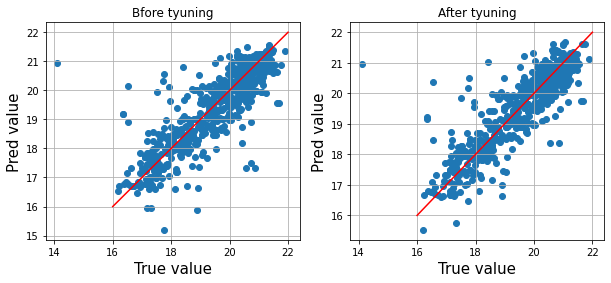

In [69]:
# パラメータチューニングする前後での散布図を並べている。

fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_pre)
x = np.linspace(16,22)
y = x
plt.plot(x,y,'r')
plt.xlabel('True value', fontsize=15)
plt.ylabel('Pred value', fontsize=15)
plt.title('Bfore tyuning', fontsize=12)
plt.grid()

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred)
x = np.linspace(16,22)
y = x
plt.plot(x,y,'r')
plt.xlabel('True value', fontsize=15)
plt.ylabel('Pred value', fontsize=15)
plt.title('After tyuning', fontsize=12)
plt.grid()
plt.show()
plt.show()

### 誤差分布

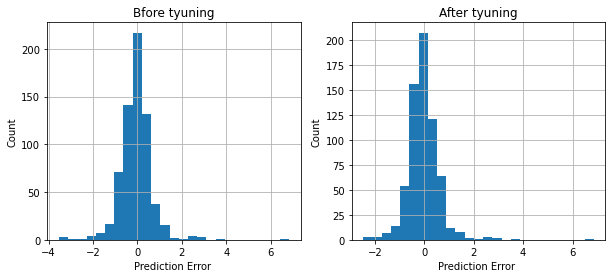

In [70]:
# パラメータチューニングする前後での予測値と実測値の差のヒストグラムを並べている。

fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
error = y_pred_pre - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error ")
plt.ylabel("Count")
plt.title('Bfore tyuning')
plt.grid()

plt.subplot(1,2,2)
error = y_pred - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error ")
plt.ylabel("Count")
plt.title('After tyuning')
plt.grid()

### 外れ値の解析

In [71]:
dff2=pd.DataFrame(y_pred-y_test).rename(columns={'キレイ度':'誤差'})
pred=pd.DataFrame(y_pred)
import scipy.stats as st

#誤差を標準化
dff2_std=pd.DataFrame(st.zscore(y_pred-y_test))
dff2_std.columns=['誤差_std']
dff2_std.index=dff2.index

# 95%
y_pred_df= pd.Series(y_pred)
dff2_index_list=dff2_std[abs(dff2_std['誤差_std'])>1.96].index

test=pd.read_pickle('result_H30.pickle')
b=pd.concat([test, dff2],axis=1)
y_pred_df.index=b.index
b['予測']=y_pred_df
out2 = b.loc[dff2_index_list]

In [72]:
# 誤差が大きい5%の地点を表示
out2

キレイ度     NO2        CO      light  都道府県      標高        誤差         予測
3    19.67   742.0  385582.0   5.500000   北海道   196.0  1.565384  21.235384
77   17.34  1666.0  427879.0  62.500000   埼玉県     2.9 -1.593105  15.746895
160  19.51   825.0  402919.0  10.500000   新潟県    68.1  1.356192  20.866192
184  19.97   823.0  388637.0   5.000000   福井県   179.7  1.340064  21.310064
221  17.51   838.0  343150.0   8.000000   山梨県   900.6  2.345513  19.855513
224  20.86   806.0  342152.0  16.000000   長野県  1528.4 -2.474521  18.385479
283  17.96   826.0  361727.0  60.000000   長野県   665.3  1.581185  19.541185
313  20.73   811.0  345267.0   6.000000   長野県  1098.7 -1.467276  19.262724
358  21.15   784.0  336425.0   5.500000   長野県   753.8 -1.436417  19.713583
365  20.56   806.0  342152.0  16.000000   長野県  1529.2 -2.174521  18.385479
453  20.89   781.0  344139.0   7.500000   長野県  1596.4 -1.397334  19.492666
459  17.76   877.0  394796.0   6.500000   岐阜県   656.6  2.752440  20.512440
521  18.89  1208.0  435987.0  62.000000   三重県     2.4 -2.240830  16.649170
523  18.55  1194.0  431074.0  62.000000   三重県     0.8 -1.376086  17.173914
524  18.92  1154.0  429707.0  61.333333   三重県     0.0 -1.920906  16.999094
525  18.95  1209.0  426591.0  61.500000   三重県    62.0 -1.495160  17.454840
579  18.55   896.0  372005.0   5.500000   奈良県   656.6  1.430070  19.980070
582  21.61   851.0  428669.0  37.000000  和歌山県    22.3 -1.870658  19.739342
583  21.69   851.0  428669.0  37.000000  和歌山県    24.3 -1.950658  19.739342
598  17.94   842.0  420102.0  35.000000   鳥取県    42.7  1.787604  19.727604
599  17.17   832.0  428365.0  54.000000   鳥取県     5.3  1.562998  18.732998
601  18.42   793.0  387717.0   8.000000   鳥取県   210.0  2.619751  21.039751
610  14.11   788.0  401256.0   8.500000   鳥取県   642.4  6.861073  20.971073
611  16.35   826.0  442103.0  53.000000   鳥取県     4.4  2.798773  19.148773
612  17.73   835.0  414027.0  16.000000   鳥取県   151.0  2.436716  20.166716
613  19.05   839.0  441492.0  56.000000   鳥取県     2.9 -1.642596  17.407404
614  16.54   836.0  441660.0  53.000000   鳥取県     0.0  1.918027  18.458027
615  16.35   842.0  440783.0  56.000000   鳥取県     6.7  2.876572  19.226572
617  16.53   799.0  420983.0  34.000000   島根県   113.1  3.855939  20.385939
620  18.96   962.0  425034.0   8.000000   岡山県    48.6  1.540978  20.500978

trainデータが令和1年のモデルが最も成績が良かったので、それを採用する。

# 特徴量エンジニアリング

In [73]:
ans = pd.read_pickle('data3.pickle') 

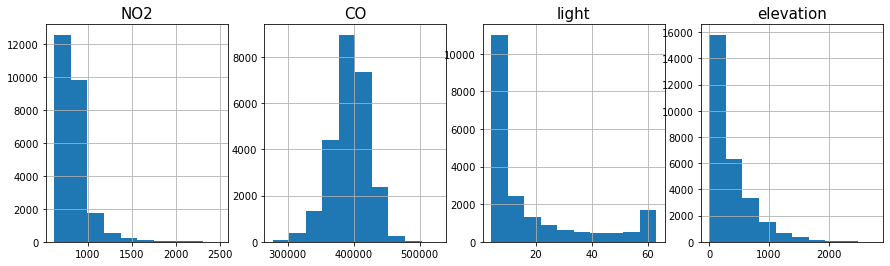

In [74]:
# 各特徴量の分布表示
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
plt.hist(ans['NO2'])
plt.title('NO2', fontsize=15)
plt.grid()

plt.subplot(1,4,2)
plt.hist(ans['CO'])
plt.title('CO', fontsize=15)
plt.xticks([300000,400000, 500000])
plt.grid()

plt.subplot(1,4,3)
plt.hist(ans['light'])
plt.title('light', fontsize=15)
plt.grid()

plt.subplot(1,4,4)
plt.hist(ans['標高'])
plt.title('elevation', fontsize=15)
plt.grid()

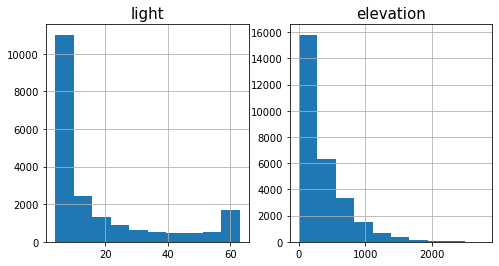

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(ans['light'])
plt.title('light', fontsize=15)
plt.grid()

plt.subplot(1,2,2)
plt.hist(ans['標高'])
plt.title('elevation', fontsize=15)
plt.grid()

## 各特徴量の分布変換

偏りがあるデータにBox-Cox変換を適用して、分布を正規分布に近づけてみる。

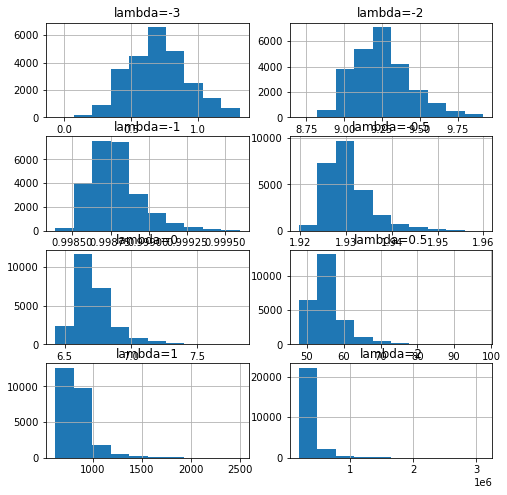

In [76]:
from scipy import stats as st

lambda_list=[-3,-2, -1, -0.5, 0, 0.5, 1, 2]

no2 = ans['NO2']

fig = plt.figure(figsize=(8, 8))

for i, i_lambda in enumerate(lambda_list):
    no2_cov=st.boxcox( no2, lmbda = i_lambda)
    fig.add_subplot(4, 2, i+1)
    plt.hist(no2_cov)
    plt.title('lambda={}'.format(i_lambda))
    plt.grid()

In [77]:
ans['標高'] = ans['標高'].map(lambda x: 0.1 if x<=0 else x)

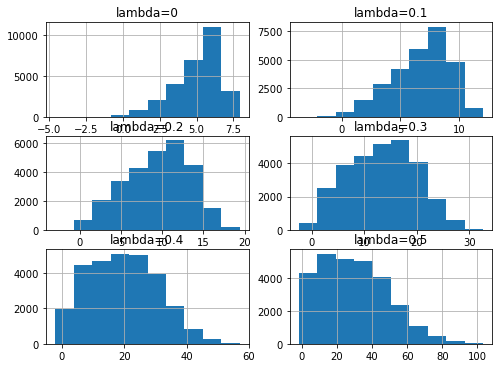

In [78]:
from scipy import stats as st

lambda_list=[0, 0.1, 0.2, 0.3, 0.4, 0.5]

hyoko = ans['標高']

fig = plt.figure(figsize=(8, 8))

for i, i_lambda in enumerate(lambda_list):
    no2_cov=st.boxcox(hyoko, lmbda = i_lambda)
    fig.add_subplot(4, 2, i+1)
    plt.hist(no2_cov)
    plt.title('lambda={}'.format(i_lambda))
    plt.grid()

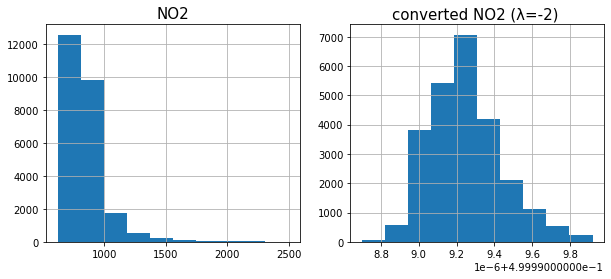

In [79]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(ans['NO2'])
plt.title('NO2', fontsize=15)
plt.grid()

plt.subplot(1,2,2)
no2_cov=st.boxcox(ans['NO2'], lmbda = -2)
plt.hist(no2_cov)
plt.title('converted NO2 (λ=-2) ', fontsize=15)
plt.grid()

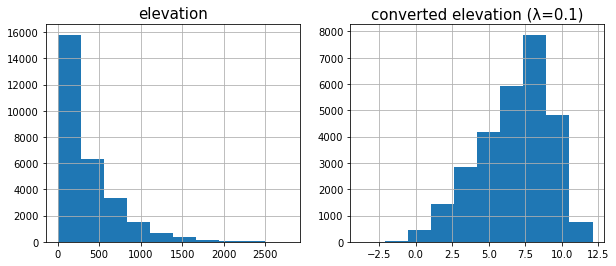

In [80]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(ans['標高'])
plt.title('elevation', fontsize=15)
plt.grid()

plt.subplot(1,2,2)
no2_cov=st.boxcox(ans['標高'], lmbda = 0.1)
plt.hist(no2_cov)
plt.title('converted elevation (λ=0.1)', fontsize=15)
plt.grid()

## 分布変換後のモデルの性能

In [81]:
test=pd.read_pickle('result_H30.pickle')
train=pd.read_pickle('result_R1.pickle')

In [82]:
train.corr()

キレイ度       NO2        CO     light        標高
キレイ度   1.000000 -0.739413 -0.522232 -0.826894  0.415963
NO2   -0.739413  1.000000  0.665217  0.637575 -0.475015
CO    -0.522232  0.665217  1.000000  0.524744 -0.869455
light -0.826894  0.637575  0.524744  1.000000 -0.443862
標高     0.415963 -0.475015 -0.869455 -0.443862  1.000000

In [83]:
test.corr()

キレイ度       NO2        CO     light        標高
キレイ度   1.000000 -0.735581 -0.633353 -0.845691  0.570602
NO2   -0.735581  1.000000  0.698737  0.655899 -0.521876
CO    -0.633353  0.698737  1.000000  0.590658 -0.862184
light -0.845691  0.655899  0.590658  1.000000 -0.538533
標高     0.570602 -0.521876 -0.862184 -0.538533  1.000000

In [84]:
from scipy import stats as st

train['NO2']=st.boxcox( train['NO2'], lmbda = -2)
test['NO2']=st.boxcox( test['NO2'], lmbda = -2)

test['標高'] = test['標高'].map(lambda x: 0.1 if x<=0 else x)
train['標高']=st.boxcox( train['標高'], lmbda = 0.1)
test['標高']=st.boxcox( test['標高'], lmbda = 0.1)

test.drop(['都道府県'], axis=1, inplace=True)
train.drop(['都道府県'],axis=1, inplace=True)

In [85]:
train.corr()

キレイ度       NO2        CO     light        標高
キレイ度   1.000000 -0.760386 -0.522232 -0.826894  0.509403
NO2   -0.760386  1.000000  0.715276  0.679479 -0.594172
CO    -0.522232  0.715276  1.000000  0.524744 -0.842753
light -0.826894  0.679479  0.524744  1.000000 -0.489109
標高     0.509403 -0.594172 -0.842753 -0.489109  1.000000

In [86]:
test.corr()

キレイ度       NO2        CO     light        標高
キレイ度   1.000000 -0.778141 -0.633353 -0.845691  0.651503
NO2   -0.778141  1.000000  0.765592  0.728793 -0.685998
CO    -0.633353  0.765592  1.000000  0.590658 -0.839277
light -0.845691  0.728793  0.590658  1.000000 -0.605336
標高     0.651503 -0.685998 -0.839277 -0.605336  1.000000

In [87]:
X_train = train.drop(['キレイ度'], axis=1)
y_train = train['キレイ度']
X_test = test.drop(['キレイ度'], axis=1)
y_test = test['キレイ度']

### パラメータチューニングする前

In [88]:
import xgboost as xgb

model = xgb.XGBRegressor(random_state=100)
model.fit(X_train, y_train)
y_pred_pre = model.predict(X_test)

print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

0.9896102518014925
0.7077787927906045


In [89]:
importances=pd.DataFrame({'fetures':X_train.columns,'importance':model.feature_importances_})
importances.sort_values('importance',ascending=False)

fetures  importance
2   light    0.594326
0     NO2    0.229115
1      CO    0.096231
3      標高    0.080328

### パラメータチューニングした後

In [90]:
model = xgb.XGBRegressor(booster = 'gbtree',
                         objective = 'reg:linear',
                         eval_metric = 'rmse',
                         random_staate=100,
                         learning_rate=0.09,
                         n_estimators= 135,
                         max_depth = 1,
                         min_child_weight = 1,
                         colsample_bytree = 1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(model.score(X_train,y_train))
print(model.score(X_test, y_test))

[15:22:27] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:22:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "random_staate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.8099667733479186
0.7838801310732288


In [91]:
importances=pd.DataFrame({'fetures':X_train.columns,'importance':model.feature_importances_})
importances.sort_values('importance',ascending=False)

fetures  importance
2   light    0.561088
0     NO2    0.321878
3      標高    0.084143
1      CO    0.032891

In [92]:
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)
np.std(y_pred-y_test)

0.6346105824312428

In [93]:
y_pred = model.predict(X_train)
mean_absolute_error(y_train, y_pred)
np.std(y_pred-y_train)

0.5856474071499852

In [94]:
0.42305950506323203-0.41642411107140326

0.006635393991828775

In [95]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)
mean_squared_error(y_test, y_pred)

0.4034402657259132

In [96]:
y_pred = model.predict(X_train)
mean_absolute_error(y_train, y_pred)
mean_squared_error(y_train, y_pred)

0.34298293999649127

## グリッドサーチ

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {'max_depth': [2, 3, 4],
              'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [70, 80, 90, 100, 110, 120],
              'min_child_weight': [1, 2, 3, 4, 5]}

model = xgb.XGBRegressor(random_staate=100)
grid_search = GridSearchCV(model, param_grid, cv=10, return_train_score=True)

# GridSearchCVは最良パラメータの探索だけでなく、それを使った学習メソッドも持っています
grid_search.fit(X_train, y_train)


[15:23:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "random_staate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:23:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "random_staate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:23:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Par

In [23]:
print('best score: {:0.3f}'.format(grid_search.score(X_test, y_test)))
print('best params: {}'.format(grid_search.best_params_))
print('best val score:  {:0.3f}'.format(grid_search.best_score_))

best score: 0.781
best params: {'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 90}
best val score:  0.636


### 散布図

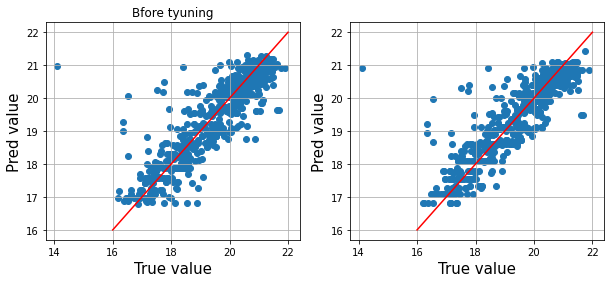

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_pre)
x = np.linspace(16,22)
y = x
plt.plot(x,y,'r')
plt.xlabel('True value', fontsize=15)
plt.ylabel('Pred value', fontsize=15)
plt.title('Bfore tyuning', fontsize=12)
plt.grid()

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred)
x = np.linspace(16,22)
y = x
plt.plot(x,y,'r')
plt.xlabel('True value', fontsize=15)
plt.ylabel('Pred value', fontsize=15)
plt.grid()
plt.show()
plt.show()

### 誤差分布

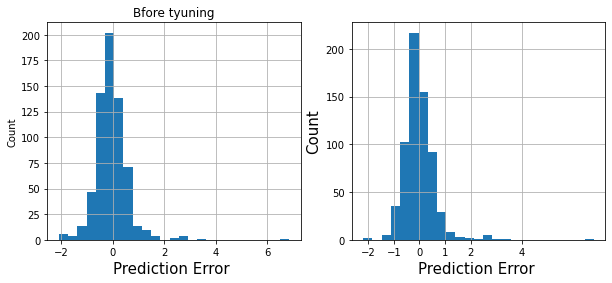

In [11]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
error = y_pred_pre - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error ", fontsize=15)
plt.ylabel("Count")
plt.title('Bfore tyuning')
plt.grid()

plt.subplot(1,2,2)
error = y_pred - y_test
plt.hist(error, bins = 25)
plt.xticks([-2,-1,0,1,2,4])
plt.xlabel("Prediction Error ", fontsize=15)
plt.ylabel("Count", fontsize=15)

plt.grid()

### 外れ値の解析

In [22]:
dff2=pd.DataFrame(y_pred-y_test).rename(columns={'キレイ度':'誤差'})
pred=pd.DataFrame(y_pred)

import scipy.stats as st

dff2_std=pd.DataFrame(st.zscore(y_pred-y_test))
dff2_std.columns=['誤差_std']
dff2_std.index=dff2.index

y_pred_df= pd.Series(y_pred)
dff2_index_list=dff2_std[abs(dff2_std['誤差_std'])>1.96].index

test=pd.read_pickle('result_H30.pickle')
b=pd.concat([test, dff2],axis=1)
y_pred_df.index=b.index
b['予測']=y_pred_df


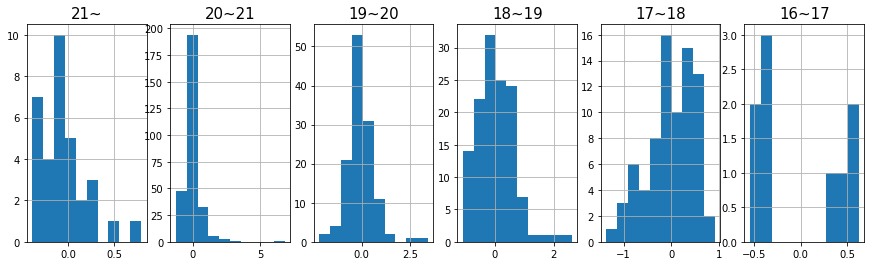

In [45]:
fig = plt.figure(figsize=(15,4))
plt.subplot(1,6,1)
plt.hist(b[b['予測']>=21]['誤差'])
plt.title('21~', fontsize=15)
plt.grid()

plt.subplot(1,6,2)
plt.hist(b[(b['予測']<21)&(b['予測']>=20)]['誤差'])
plt.title('20~21', fontsize=15)
plt.grid()

plt.subplot(1,6,3)
plt.hist(b[(b['予測']<20)&(b['予測']>=19)]['誤差'])
plt.title('19~20', fontsize=15)
plt.grid()

plt.subplot(1,6,4)
plt.hist(b[(b['予測']<19)&(b['予測']>=18)]['誤差'])
plt.title('18~19', fontsize=15)
plt.grid()

plt.subplot(1,6,5)
plt.hist(b[(b['予測']<18)&(b['予測']>=17)]['誤差'])
plt.title('17~18', fontsize=15)
plt.grid()

plt.subplot(1,6,6)
plt.hist(b[(b['予測']<17)&(b['予測']>=16)]['誤差'])
plt.title('16~17', fontsize=15)
plt.grid()

In [36]:
b

キレイ度    NO2        CO  light  都道府県     標高        誤差         予測
0    19.65  733.0  394040.0   38.0   北海道  103.4  0.493358  20.143358
1    19.77  749.0  382193.0   46.0   北海道  150.7 -0.102365  19.667635
2    20.14  749.0  382193.0   46.0   北海道  150.8 -0.472365  19.667635
3    19.67  742.0  385582.0    5.5   北海道  196.0  1.234665  20.904665
4    20.53  693.0  364719.0   16.0   北海道  370.0  0.057177  20.587177
..     ...    ...       ...    ...   ...    ...       ...        ...
694  19.52  802.0  423454.0   61.0   宮崎県   15.3 -0.705181  18.814819
695  20.96  790.0  415124.0   13.0   宮崎県  248.8 -0.309415  20.650585
696  18.45  765.0  425862.0   45.0  鹿児島県    5.6  1.058406  19.508406
697  20.63  738.0  371641.0   11.0  鹿児島県  545.4  0.211257  20.841257
698  21.76  683.0  464895.0    8.0  鹿児島県  129.2 -0.325041  21.434959

[659 rows x 8 columns]

In [16]:
out2 = b.loc[dff2_index_list]
out2 

キレイ度     NO2        CO  light  都道府県     標高        誤差         予測
3    19.67   742.0  385582.0    5.5   北海道  196.0  1.234665  20.904665
206  17.21   926.5  404424.0   63.0   山梨県  261.0  1.399144  18.609144
221  17.51   838.0  343150.0    8.0   山梨県  900.6  2.787516  20.297516
250  19.08   788.0  360197.0   14.0   長野県  709.7  1.491314  20.571314
459  17.76   877.0  394796.0    6.5   岐阜県  656.6  2.653763  20.413763
579  18.55   896.0  372005.0    5.5   奈良県  656.6  1.800355  20.350355
582  21.61   851.0  428669.0   37.0  和歌山県   22.3 -2.113788  19.496212
583  21.69   851.0  428669.0   37.0  和歌山県   24.3 -2.193788  19.496212
597  18.71   827.0  416317.0   23.0   鳥取県   11.8  1.285546  19.995546
598  17.94   842.0  420102.0   35.0   鳥取県   42.7  1.556212  19.496212
599  17.17   832.0  428365.0   54.0   鳥取県    5.3  1.783827  18.953827
601  18.42   793.0  387717.0    8.0   鳥取県  210.0  2.484665  20.904665
610  14.11   788.0  401256.0    8.5   鳥取県  642.4  6.794665  20.904665
611  16.35   826.0  442103.0   53.0   鳥取県    4.4  2.853047  19.203047
612  17.73   835.0  414027.0   16.0   鳥取県  151.0  2.496074  20.226074
614  16.54   836.0  441660.0   53.0   鳥取県    0.0  2.129327  18.669327
615  16.35   842.0  440783.0   56.0   鳥取県    6.7  2.603827  18.953827
617  16.53   799.0  420983.0   34.0   島根県  113.1  3.438067  19.968067
620  18.96   962.0  425034.0    8.0   岡山県   48.6  1.407491  20.367491
625  18.71  1789.0  492899.0   61.5   岡山県    1.3 -1.367431  17.342569

NO2データと標高データの分布を変換することにより、精度が少し上がり、過学習の程度がかなり小さくなったので、分布変換を適用する。

# 星空マップ作成

## モデルを実装

In [148]:
# 日本全土のNO2,CO,夜間光、標高データ
test=pd.read_pickle('data3.pickle')

# 令和１年の約400地点のキレイ度とNO2,CO,夜間光、標高データ
train=pd.read_pickle('result_R1.pickle')

In [149]:
# 欠損値を適当な数字で埋める
test['light'] = test['light'].fillna(5)
test['NO2'] = test['NO2'].fillna(700)
test['CO'] = test['CO'].fillna(350000)

In [150]:
# Box-Cox変換
from scipy import stats as st

train['NO2']=st.boxcox( train['NO2'], lmbda = -2)
test['NO2']=st.boxcox( test['NO2'], lmbda = -2)

test['標高'] = test['標高'].map(lambda x: 0.1 if x<=0 else x)
train['標高']=st.boxcox( train['標高'], lmbda = 0.3)
test['標高']=st.boxcox( test['標高'], lmbda = 0.3)

test.drop(['緯度','経度'], axis=1, inplace=True)
train.drop(['都道府県'],axis=1, inplace=True)

In [151]:
X_train = train.drop(['キレイ度'], axis=1)
y_train = train['キレイ度']

In [152]:
import xgboost as xgb

model = xgb.XGBRegressor(booster = 'gbtree',
                         objective = 'reg:linear',
                         eval_metric = 'rmse',
                         random_staate=100,
                         learning_rate=0.09,
                         n_estimators= 135,
                         max_depth = 1,
                         min_child_weight = 1,
                         colsample_bytree = 1)

model.fit(X_train, y_train)
y_pred = model.predict(test)

print(model.score(X_train,y_train))

[19:32:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.7968968963553191


In [153]:
test=pd.read_pickle('data3.pickle')
map2 = pd.DataFrame([y_pred, test['緯度'], test['経度']]).T

In [154]:
map2.columns = ['キレイ度','経度','緯度']

In [158]:
pd.concat([map2, map_]).to_pickle('data4.pickle')

C:\Users\umeyu\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\umeyu\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\umeyu\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32239 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\umeyu\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 32076 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\umeyu\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 24230 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\umeyu\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 32239 missing from curre

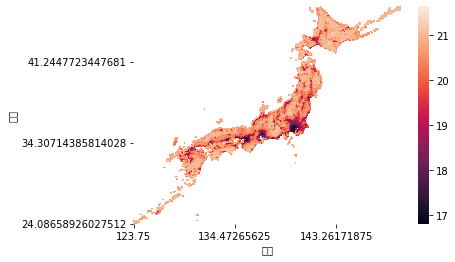

In [56]:
import seaborn as sns

df_flights_pivot2 = pd.pivot_table(data=map2, values='キレイ度', 
                                  columns='経度', index='緯度', aggfunc=np.mean)

ax2 = sns.heatmap(df_flights_pivot2, xticklabels=200, yticklabels=200)
ax2.invert_yaxis()

In [57]:
map2.to_pickle('data4.pickle')

## geojsonファイルを作成

In [159]:
# 日本全土のキレイ度と緯度経度データ
data = pd.read_pickle('data4.pickle')

In [160]:
data

キレイ度          経度         緯度
0   20.804956  123.750000  24.447150
1   20.981321  123.750000  24.407138
2   21.637159  123.750000  24.367114
3   21.106865  123.750000  24.327077
4   21.637159  123.750000  24.287027
..        ...         ...        ...
33  20.682028  139.965820  39.943436
34  20.257517  140.009766  40.078071
35  20.506737  140.009766  40.044438
36  20.506737  140.009766  40.010787
37  20.682028  140.009766  39.977120

[28414 rows x 3 columns]

In [161]:
ido = data['緯度']
keido = data['経度']
kirei = data['キレイ度']

In [5]:
len(keido.unique())

529

In [6]:
len(ido.unique())

537

In [162]:
# 行を緯度、列を経度にしたからのデータフレームを作成
b = [[0.0]*len(keido.unique())]*len(ido.unique())
a = pd.DataFrame(b)
a.index = np.sort(ido.unique())[::-1]
a.columns = np.sort(keido.unique())

In [163]:
# 空のデータフレームにキレイ度を入れる
from tqdm.notebook import tqdm

for x, y, c in tqdm(zip(ido, keido, kirei)):
    a.loc[x][y]=c

In [82]:
a.columns[:30]

Float64Index([        123.75, 123.7939453125,  123.837890625, 123.8818359375,
                123.92578125, 123.9697265625,  124.013671875, 124.0576171875,
                 124.1015625, 124.1455078125,  124.189453125, 124.2333984375,
                124.27734375, 124.3212890625,  124.541015625,   124.62890625,
              124.6728515625,  124.716796875, 125.1123046875,      125.15625,
              125.2001953125,  125.244140625, 125.2880859375,   125.33203125,
              125.3759765625,  125.419921875, 125.4638671875, 126.6943359375,
                126.73828125, 126.7822265625],
             dtype='float64')

In [85]:
a.index[-15:]

Float64Index([24.766784524910523,   24.7268748725437,  24.68695241403656,
              24.647017164668416, 24.607069139748393, 24.567108354615335,
                24.5271348246378,  24.48714856521409,  24.44714959177213,
              24.407137919769607, 24.367113564693856, 24.327076542061874,
              24.287026867420312, 24.246964556345464,  24.08658926027512],
             dtype='float64')

## 穴埋め

In [106]:
#佐賀

fill = a[[130.078125, 130.1220703125,  130.166015625, 130.2099609375,
   130.25390625, 130.2978515625,  130.341796875, 130.3857421875,
   130.4296875, 130.4736328125,]]\
.loc[[33.3947592204501,
      33.35806161465179,  33.32134852857253,  33.28461997076218,
      33.247875949799656,  33.21111647429291,  33.17434155287894,
      33.13755119422381]]

In [108]:
# 名古屋

fill= a[[ 136.6259765625,
   136.669921875, 136.7138671875,    136.7578125, 136.8017578125,
   136.845703125]]\
.loc[[35.60371874252047,  35.56798045983608,  35.53222622952817,
   35.49645605840977,  35.46066995332171, 35.424867921132794,
    35.3890499687397,  35.35321610306709,  35.31736633106753,
  35.281500659721665,   35.2456190960381,  35.20972164705347,
  35.173808319832496,  35.13787912146791,  35.10193405908059,
  35.065973139819526,   35.0299963708618]]

In [110]:
# 新潟

fill = a[[138.955078125, 138.9990234375,
    139.04296875, 139.0869140625,  139.130859375]]\
.loc[[ 37.92686760325009,  37.89219554901394,
               37.85750715802246,  37.82280243529882,  37.78808138589254,
               37.75334401487949,  37.71859032736187]]

In [112]:
# 秋田

fill = a[[139.921875, 139.9658203125,  140.009765625, 140.0537109375,
    140.09765625, 140.1416015625]]\
.loc[[40.11168866731089,  40.07807142916587,  40.04443758632519,
  40.010787142182984,  39.97712010015794, 39.943436463693374,
  39.909736236257196]]

In [107]:
l =[]

for col in fill.columns:
    zero = fill[fill[col]==0].index
    for ind in zero:
        l.append([ind, col])

In [113]:
for col in fill.columns:
    zero = fill[fill[col]==0].index
    for ind in zero:
        l.append([ind, col])
    

In [119]:
data = pd.DataFrame(l, columns=['緯度','経度'])

In [121]:
data['標高']=10

In [123]:

# NO2とCOのデータ
air_df = pd.read_pickle('air.pickle')

# 夜間光データ
light_df = pd.read_pickle('light.pickle')

In [124]:
# 緯度経度、標高データに合わせてNO2、CO、夜間光データを合体する
from tqdm.notebook import tqdm

ans=[]

for x,y,h in tqdm(zip(data['経度'], data['緯度'], data['標高'])):
    z1=air_df[(air_df['x_min']<x) & (x < air_df['x_max']) & (air_df['y_min']<y) & (y < air_df['y_max'])]
    z2=z1['no2'].values.mean()
    z3=z1['co'].values.mean()
    z4=light_df[(light_df['x_min']<x) & (x < light_df['x_max']) & (light_df['y_min']<y) & (y < light_df['y_max'])]
    z4=z4['light'].values.mean()
    ans.append([z2,z3,z4,h,x,y])
        

ans=pd.DataFrame(ans,columns=['NO2','CO','light','標高','緯度','経度'])

C:\Users\umeyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
C:\Users\umeyu\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\umeyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
C:\Users\umeyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\umeyu\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\umeyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
C:\Users\umeyu\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.t

In [126]:
ans.to_pickle('fill_data.pickle')

In [136]:
test = pd.read_pickle('fill_data.pickle')

In [137]:
# 欠損値を適当な数字で埋める
test['light'] = test['light'].fillna(5)
test['NO2'] = test['NO2'].fillna(700)
test['CO'] = test['CO'].fillna(350000)

In [138]:
# Box-Cox変換
from scipy import stats as st

test['NO2']=st.boxcox( test['NO2'], lmbda = -2)


test['標高']=st.boxcox( test['標高'], lmbda = 0.3)

test.drop(['緯度','経度'], axis=1, inplace=True)

In [140]:
import xgboost as xgb

model = xgb.XGBRegressor(booster = 'gbtree',
                         objective = 'reg:linear',
                         eval_metric = 'rmse',
                         random_staate=100,
                         learning_rate=0.09,
                         n_estimators= 135,
                         max_depth = 1,
                         min_child_weight = 1,
                         colsample_bytree = 1)

model.fit(X_train, y_train)
y_pred = model.predict(test)

print(model.score(X_train,y_train))

[19:19:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.7968968963553191


In [143]:
test=pd.read_pickle('fill_data.pickle')
map_ = pd.DataFrame([y_pred, test['緯度'], test['経度']]).T

In [145]:
map_.columns = ['キレイ度','経度','緯度']

In [164]:
old_col = a.columns

In [165]:
old_col[0]

123.75

In [166]:
# マップの謎のずれ修正
new_col = []

for i, col in enumerate(old_col):
    if i != 0:
        new_col.append(col)

In [167]:
new_col.append(new_col[-1]-new_col[-2]+new_col[-1])

In [168]:
new_col[-1]-new_col[-2]+new_col[-1]

148.974609375

In [169]:
a.columns = new_col

In [170]:
a

123.793945  123.837891  123.881836  123.925781  123.969727  \
45.583290    0.000000    0.000000    0.000000    0.000000    0.000000   
45.552525    0.000000    0.000000    0.000000    0.000000    0.000000   
45.521744    0.000000    0.000000    0.000000    0.000000    0.000000   
45.490946    0.000000    0.000000    0.000000    0.000000    0.000000   
45.460131    0.000000    0.000000    0.000000    0.000000    0.000000   
...               ...         ...         ...         ...         ...   
24.367114   21.637159   21.637159   21.106865   21.637159   20.804956   
24.327077   21.106865   21.106865   21.106865   21.414522    0.000000   
24.287027   21.637159   21.637159   21.414522   20.884228   20.520456   
24.246965    0.000000    0.000000    0.000000   20.804956   20.804956   
24.086589   20.804956   20.804956    0.000000    0.000000    0.000000   

           124.013672  124.057617  124.101562  124.145508  124.189453  ...  \
45.583290    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
45.552525    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
45.521744    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
45.490946    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
45.460131    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
...               ...         ...         ...         ...         ...  ...   
24.367114   20.804956    0.000000   20.804956   20.804956   19.920721  ...   
24.327077   20.520456    0.000000   20.804956    0.000000    0.000000  ...   
24.287027   20.804956   20.804956    0.000000    0.000000    0.000000  ...   
24.246965   20.804956   20.520456    0.000000    0.000000    0.000000  ...   
24.086589    0.000000    0.000000    0.000000    0.000000    0.000000  ...   

           148.535156  148.579102  148.623047  148.666992  148.710938  \
45.583290    0.000000    0.000000    0.000000    0.000000    0.000000   
45.552525    0.000000    0.000000    0.000000   20.804956   21.027594   
45.521744    0.000000   20.520456   20.804956   21.027594   21.043457   
45.490946    0.000000   20.981321   21.027594   21.106865   21.106865   
45.460131   20.981321   21.027594   21.043457   21.106865   21.043457   
...               ...         ...         ...         ...         ...   
24.367114    0.000000    0.000000    0.000000    0.000000    0.000000   
24.327077    0.000000    0.000000    0.000000    0.000000    0.000000   
24.287027    0.000000    0.000000    0.000000    0.000000    0.000000   
24.246965    0.000000    0.000000    0.000000    0.000000    0.000000   
24.086589    0.000000    0.000000    0.000000    0.000000    0.000000   

           148.754883  148.798828  148.842773  148.886719  148.930664  
45.583290   20.981321   21.027594   20.804956    0.000000    0.000000  
45.552525   21.027594   21.043457   21.043457   21.027594    0.000000  
45.521744   21.043457   21.043457   21.028561   21.106865   20.804956  
45.490946   21.043457   21.043457   21.043457   21.043457    0.000000  
45.460131   21.043457   21.043457   20.997185    0.000000    0.000000  
...               ...         ...         ...         ...         ...  
24.367114    0.000000    0.000000    0.000000    0.000000    0.000000  
24.327077    0.000000    0.000000    0.000000    0.000000    0.000000  
24.287027    0.000000    0.000000    0.000000    0.000000    0.000000  
24.246965    0.000000    0.000000    0.000000    0.000000    0.000000  
24.086589    0.000000    0.000000    0.000000    0.000000    0.000000  

[537 rows x 529 columns]

In [171]:
k[0]

NameError: name 'k' is not defined

In [172]:
j[0]

NameError: name 'j' is not defined

In [173]:
# 点データを面データに変換
k = a.columns
j = a.index
geo = []
pro = []

for i in tqdm(range(len(k)-1)):
    for z in range(len(j)-1):
        
        my = a[k[i]][j[z]]
        down = a[k[i]][j[z+1]]
        right = a[k[i+1]][j[z]]
        dr = a[k[i+1]][j[z+1]]

        l = []
        if my != 0:
            l.append([k[i], j[z]])
        if right != 0:
            l.append([k[i+1], j[z]])
        if dr != 0:
            l.append([k[i+1], j[z+1]])
        if down != 0:
            l.append([k[i], j[z+1]])
        
        v = (down + right + dr + my)/len(l)

        if len(l)>=3:
            geo.append(l)
            pro.append(v)

C:\Users\umeyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


In [175]:
# geojsonファイルを作成
import csv, json
from geojson import Feature, FeatureCollection, Polygon

features = []

for g, c in zip(geo, pro):
    features.append(
        Feature(
            geometry = Polygon([g]),
            properties = {
                'clean': c
            }
        )
    )

collection = FeatureCollection(features)
with open("data_polygon3.json", "w") as f:
    f.write('%s' % collection)

# 北九州

In [41]:
# ピクセルの緯度経度を返す関数
def pixel_to_latlng(pixel_x, pixel_y,zoom = 7):
    L = 85.05112878
    longitude = 180*(pixel_x/(2**(zoom+7))-1)
    latitude = 180*(np.arcsin(np.tanh(-np.pi*pixel_y/(2**(zoom+7))+np.arctanh(np.sin(np.pi*L/180)))))/np.pi
    return latitude,longitude

# タイル画像の緯度経度、標高のデータフレームを返す関数
def get_hyoko(x, y, z):
    
    # 任意のタイル画像の1ピクセルの標高を256×256のデータフレームで取得
    url = "https://cyberjapandata.gsi.go.jp/xyz/demgm/{z}/{x}/{y}.txt ".format(z=z,x=x,y=y)
    df = pd.read_csv(url, header=None).replace("e",0)
    ind = []
    col = []
    
    # 取得した画像のピクセルの緯度経度を取得
    for i in range(256):
        a, b = pixel_to_latlng(x*256 + i, y*256 + i,zoom = z)
        ind.append(a)
        col.append(b)

    # データフレームの列を経度に、行を緯度に変換
    df.index = ind
    df.columns = col
    
    # 標高の値をflaat型に変換
    df = df.astype(float)

    # 標高が0より高い地点の緯度経度と標高のデータフレームを返す
    latlon = []
    for k in df.columns:
        ind = df[df[k]>0][k].index
        hyoko = df[df[k]>0][k].values
        for i, h in zip(ind, hyoko):
            latlon.append([h, i, k])

    return pd.DataFrame(latlon, columns = ['標高', '緯度', '経度'])

In [42]:
# zoom率　5で日本があるタイル画像の緯度経度、標高を取得
k1 = get_hyoko(220,102,8)
k2 = get_hyoko(221,102,8)

In [43]:
data = pd.concat([k1, k2])

In [44]:
data

標高         緯度          経度
0       23.0  34.302606  129.375000
1       49.0  34.298068  129.375000
2       61.0  34.293530  129.375000
3       37.0  34.288992  129.375000
4        2.0  33.234093  129.375000
...      ...        ...         ...
38046  170.0  33.436026  132.182007
38047  245.0  33.431441  132.182007
38048  312.0  33.426857  132.182007
38049  169.0  33.422272  132.182007
38050   24.0  33.417687  132.182007

[61829 rows x 3 columns]

In [45]:
# NO2とCOのデータ
air_df = pd.read_pickle('air.pickle')

# 夜間光データ
light_df = pd.read_pickle('light.pickle')

In [46]:
# 緯度経度、標高データに合わせてNO2、CO、夜間光データを合体する
from tqdm.notebook import tqdm

ans=[]

for x,y,h in tqdm(zip(data['経度'], data['緯度'], data['標高'])):
    z1=air_df[(air_df['x_min']<x) & (x < air_df['x_max']) & (air_df['y_min']<y) & (y < air_df['y_max'])]
    z2=z1['no2'].values.mean()
    z3=z1['co'].values.mean()
    z4=light_df[(light_df['x_min']<x) & (x < light_df['x_max']) & (light_df['y_min']<y) & (y < light_df['y_max'])]
    z4=z4['light'].values.mean()
    ans.append([z2,z3,z4,h,x,y])
        

ans=pd.DataFrame(ans,columns=['NO2','CO','light','標高','緯度','経度'])

C:\Users\umeyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
C:\Users\umeyu\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\umeyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
C:\Users\umeyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\umeyu\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\umeyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
C:\Users\umeyu\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.t

In [47]:
ans

NO2        CO  light     標高          緯度         経度
0        NaN       NaN    NaN   23.0  129.375000  34.302606
1        NaN       NaN    NaN   49.0  129.375000  34.298068
2        NaN       NaN    NaN   61.0  129.375000  34.293530
3        NaN       NaN    NaN   37.0  129.375000  34.288992
4        NaN       NaN    NaN    2.0  129.375000  33.234093
...      ...       ...    ...    ...         ...        ...
61824  859.0  425515.0    NaN  170.0  132.182007  33.436026
61825  859.0  425515.0    NaN  245.0  132.182007  33.431441
61826  859.0  425515.0    NaN  312.0  132.182007  33.426857
61827  868.0  425484.0    NaN  169.0  132.182007  33.422272
61828  868.0  425484.0    NaN   24.0  132.182007  33.417687

[61829 rows x 6 columns]

In [48]:
ans.to_pickle('kitakyu.pickle')

In [49]:
# 日本全土のNO2,CO,夜間光、標高データ
test=pd.read_pickle('kitakyu.pickle')

# 令和１年の約400地点のキレイ度とNO2,CO,夜間光、標高データ
train=pd.read_pickle('result_R1.pickle')

In [50]:
# 欠損値を適当な数字で埋める
test['light'] = test['light'].fillna(5)
test['NO2'] = test['NO2'].fillna(700)
test['CO'] = test['CO'].fillna(350000)

In [51]:
# Box-Cox変換
from scipy import stats as st

train['NO2']=st.boxcox( train['NO2'], lmbda = -2)
test['NO2']=st.boxcox( test['NO2'], lmbda = -2)

test['標高'] = test['標高'].map(lambda x: 0.1 if x<=0 else x)
train['標高']=st.boxcox( train['標高'], lmbda = 0.3)
test['標高']=st.boxcox( test['標高'], lmbda = 0.3)

test.drop(['緯度','経度'], axis=1, inplace=True)
train.drop(['都道府県'],axis=1, inplace=True)

In [52]:
X_train = train.drop(['キレイ度'], axis=1)
y_train = train['キレイ度']

In [53]:
import xgboost as xgb

model = xgb.XGBRegressor(booster = 'gbtree',
                         objective = 'reg:linear',
                         eval_metric = 'rmse',
                         random_staate=100,
                         learning_rate=0.09,
                         n_estimators= 135,
                         max_depth = 1,
                         min_child_weight = 1,
                         colsample_bytree = 1)

model.fit(X_train, y_train)
y_pred = model.predict(test)

print(model.score(X_train,y_train))

[14:24:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.7968968963553191


In [54]:
test=pd.read_pickle('kitakyu.pickle')
map2 = pd.DataFrame([y_pred, test['緯度'], test['経度']]).T

In [55]:
map2.columns = ['キレイ度','経度','緯度']

C:\Users\umeyu\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\umeyu\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\umeyu\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32239 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\umeyu\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 32076 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\umeyu\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 24230 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\umeyu\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 32239 missing from curre

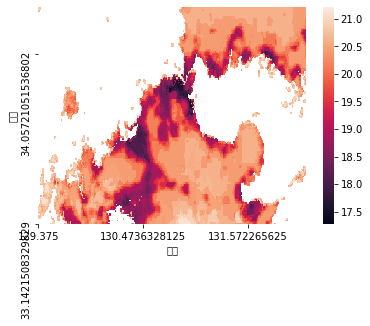

In [56]:
import seaborn as sns

df_flights_pivot2 = pd.pivot_table(data=map2, values='キレイ度', 
                                  columns='経度', index='緯度', aggfunc=np.mean)

ax2 = sns.heatmap(df_flights_pivot2, xticklabels=200, yticklabels=200)
ax2.invert_yaxis()